# MIE1517 Progress Report - Group 7: Protective Eyewear Detection and Verification
Connor Lee, Cris Carreiro,\
Gibran Rajput, Shayan Shakeri-Nezhad, Vivek Dindayal


Here we present current results in the safety glasses detection and verification project. The report is divided in two parts: details on the detection model, YOLOv5, and the CNN classifier. Data, training, and results details will be provided separately for both models for clarity.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import splitfolders
import time
from tqdm import tqdm

import fiftyone as fo
import fiftyone.zoo as foz
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models
from torchvision import datasets
from torch.utils.data import DataLoader

from ultralytics import YOLO
import IPython.display as display
from IPython.display import Image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## YOLOv5 Detection Model Details

### Data Collection and Visualization

For the preliminary detection testing we use the YOLOv5 model from Ultralytics. The data used in this stage is from the Google Open Images dataset - simply due to the large amount of labeled examples available and ease of access. Additionally, since we are fine tuning to human faces it is convenient that the dataset provides these bounding boxes. We use the Python module [FiftyOne](https://docs.voxel51.com/) to load and visualize the data before downloading locally.

To load the open images dataset,

In [ ]:
target = "open-images-v7"
train_set   = foz.load_zoo_dataset(
                                target, 
                                split       = "train",
                                label_types = ["detections"],
                                classes     = ["Human face"],
                                max_samples = 800,
                                shuffle     = True)



Found 2 images, downloading the remaining 798
 100% |███████████████████| 798/798 [10.9s elapsed, 0s remaining, 63.8 files/s]      
Dataset info written to '/home/connor/fiftyone/open-images-v7/info.json'
Loading 'open-images-v7' split 'train'
 100% |█████████████████| 800/800 [6.1s elapsed, 0s remaining, 123.6 samples/s]      
Dataset 'open-images-v7-train-800' created


And for visualization:

In [ ]:
# GUI visualization
session = fo.launch_app(train_set)

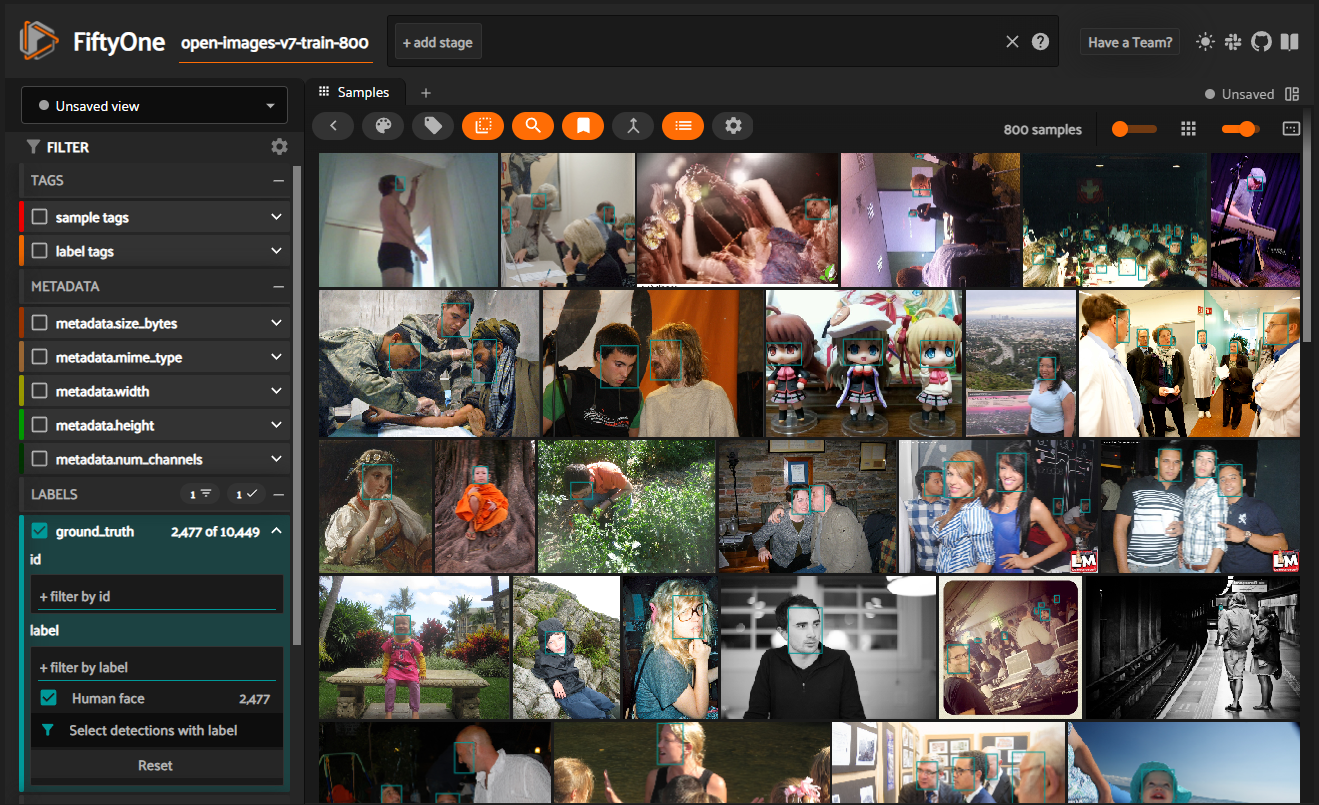

In [76]:
Image("fiftyone_vis.png")

The GUI session lets us visualize and inspect the data easily, filtering for the "Human face" class. We see the dataset contains many examples which are not necessarily the most clean nor accurate - however this should be sufficient for our purposes since we expect the test/real data to be clean and accurate.

Here we also save the data locally with the built in export function. Normally it is possible to export data splits directly, though this was done externally after saving the data. 

In [ ]:
export_dir = "./datadir" 
train_set.export(
    export_dir   = export_dir,
    dataset_type = fo.types.YOLOv5Dataset,
    label_field  = "ground_truth",
    classes      = ["Human face"],
)


data splitting to YOLO format:

In [ ]:
# images = [os.path.join('./datadir/images', x) for x in os.listdir('./datadir/images')]
# annotations = [os.path.join('./datadir/labels', x) for x in os.listdir('./datadir/labels') if x[-3:] == "txt"]

# images.sort()
# annotations.sort()

# # Split the dataset into train-valid-test splits 
# train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
# val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

# !mkdir ~/mie1517-project/splitset
# !mkdir ~/mie1517-project/splitset/images
# !mkdir ~/mie1517-project/splitset/labels
# !mkdir ~/mie1517-project/splitset/images/train ~/mie1517-project/splitset/images/val ~/mie1517-project/splitset/images/test ~/mie1517-project/splitset/labels/train ~/mie1517-project/splitset/labels/val ~/mie1517-project/splitset/labels/test

# #Utility function to move images 
# def move_files_to_folder(list_of_files, destination_folder):
#     for f in list_of_files:
#         try:
#             shutil.copy(f, destination_folder)
#         except:
#             print(f)
#             assert False

# # Move the splits into their folders
# move_files_to_folder(train_images, './splitset/images/train')
# move_files_to_folder(val_images, './splitset/images/val/')
# move_files_to_folder(test_images, './splitset/images/test/')
# move_files_to_folder(train_annotations, './splitset/labels/train/')
# move_files_to_folder(val_annotations, './splitset/labels/val/')
# move_files_to_folder(test_annotations, './splitset/labels/test/')

### Training Details
Training code is as follows, using the ultralytics API. We will not be including the training log in this notebook, but it is available upon request. It takes approximately 8-10 minutes to train 50 epochs with 800 examples. We use Adam optimizer and a batch size of 16. Other hyperparameters were tested, but not extensively. The goal to date was to have a working model.

splitset/dataset.yaml describes the data splitting, ensuring validation and test data from the Open Images dataset we downloaded earlier (named trainset) are not used in the training done by the ultralytics API. Our model is also saved as a PyTorch comaptible model, able to be loaded with either the ultralytics module, the YOLOv5 source code, or PyTorch using 

``` torch.hub.load(/path/to/yolov5/model.pt, 'custom', force_reload=True, path=model_path, source='local') ```

In [ ]:
model = YOLO('yolov5su.pt')

results = model.train(
    data='splitset/dataset.yaml',       # Path to your data configuration file
    epochs      = 50,                   # Number of training epochs
    imgsz       = 640,                  # Image size
    batch       = 16,                   # Batch size
    name        = 'yolo_humanface',     # Name of the training run
    pretrained  = True,                 # Use pre-trained weights
    workers     = 4,
    optimizer   = "Adam",
)

Here we present some images from training such as the loss curves and confusion matrix as well as some training examples. Note that normalizing the confusion matrix would provide an accuracy of 73%, however this is deemed sufficient due to data noise and mislabeling in the training examples.

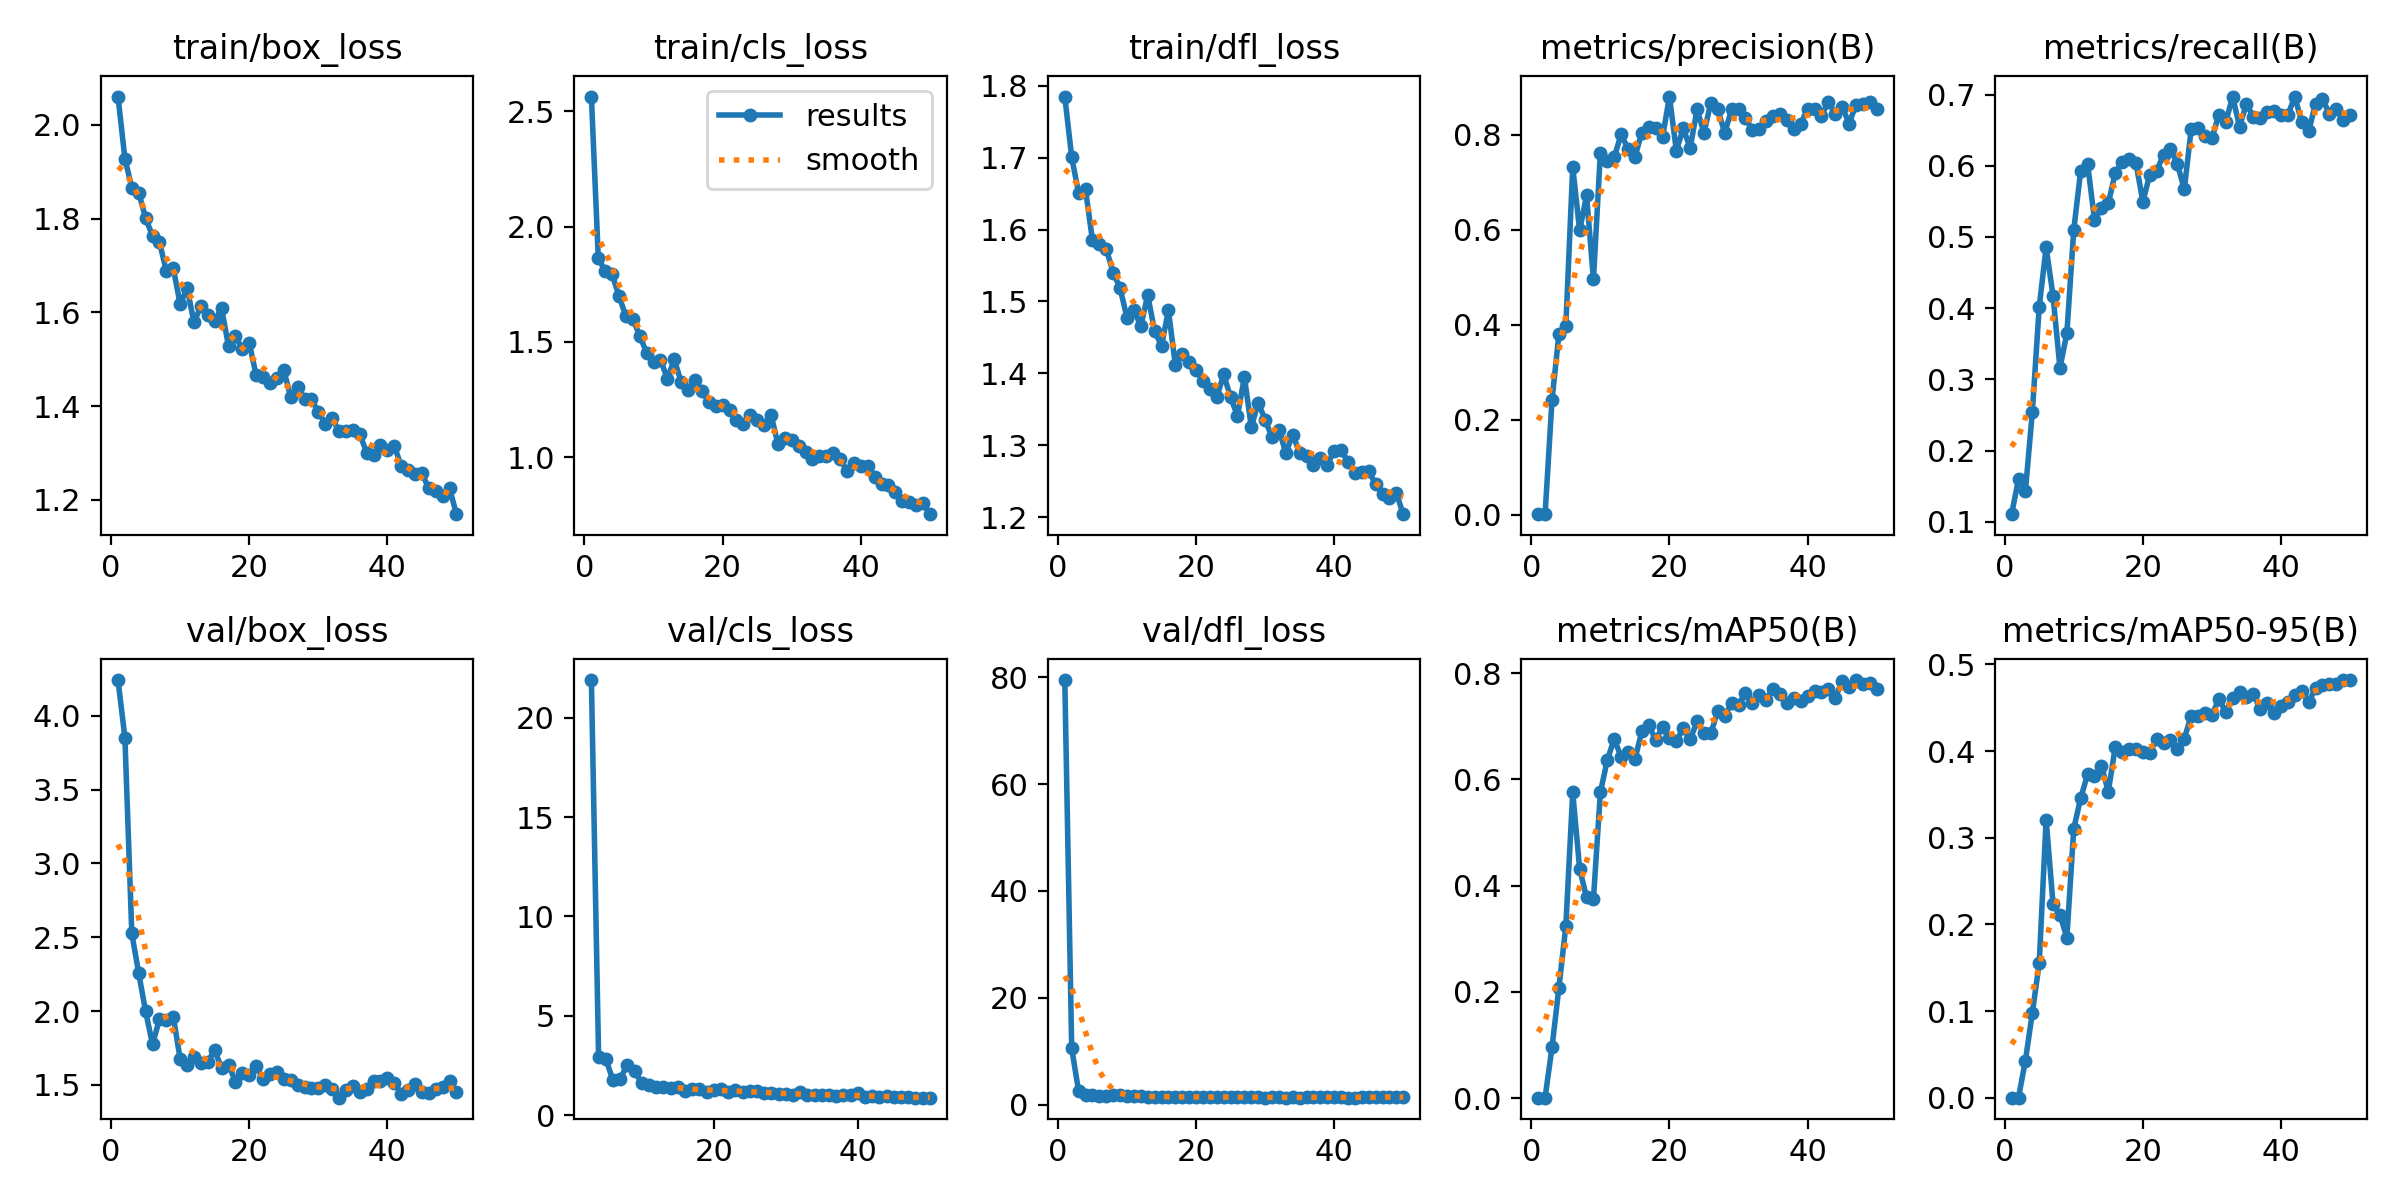

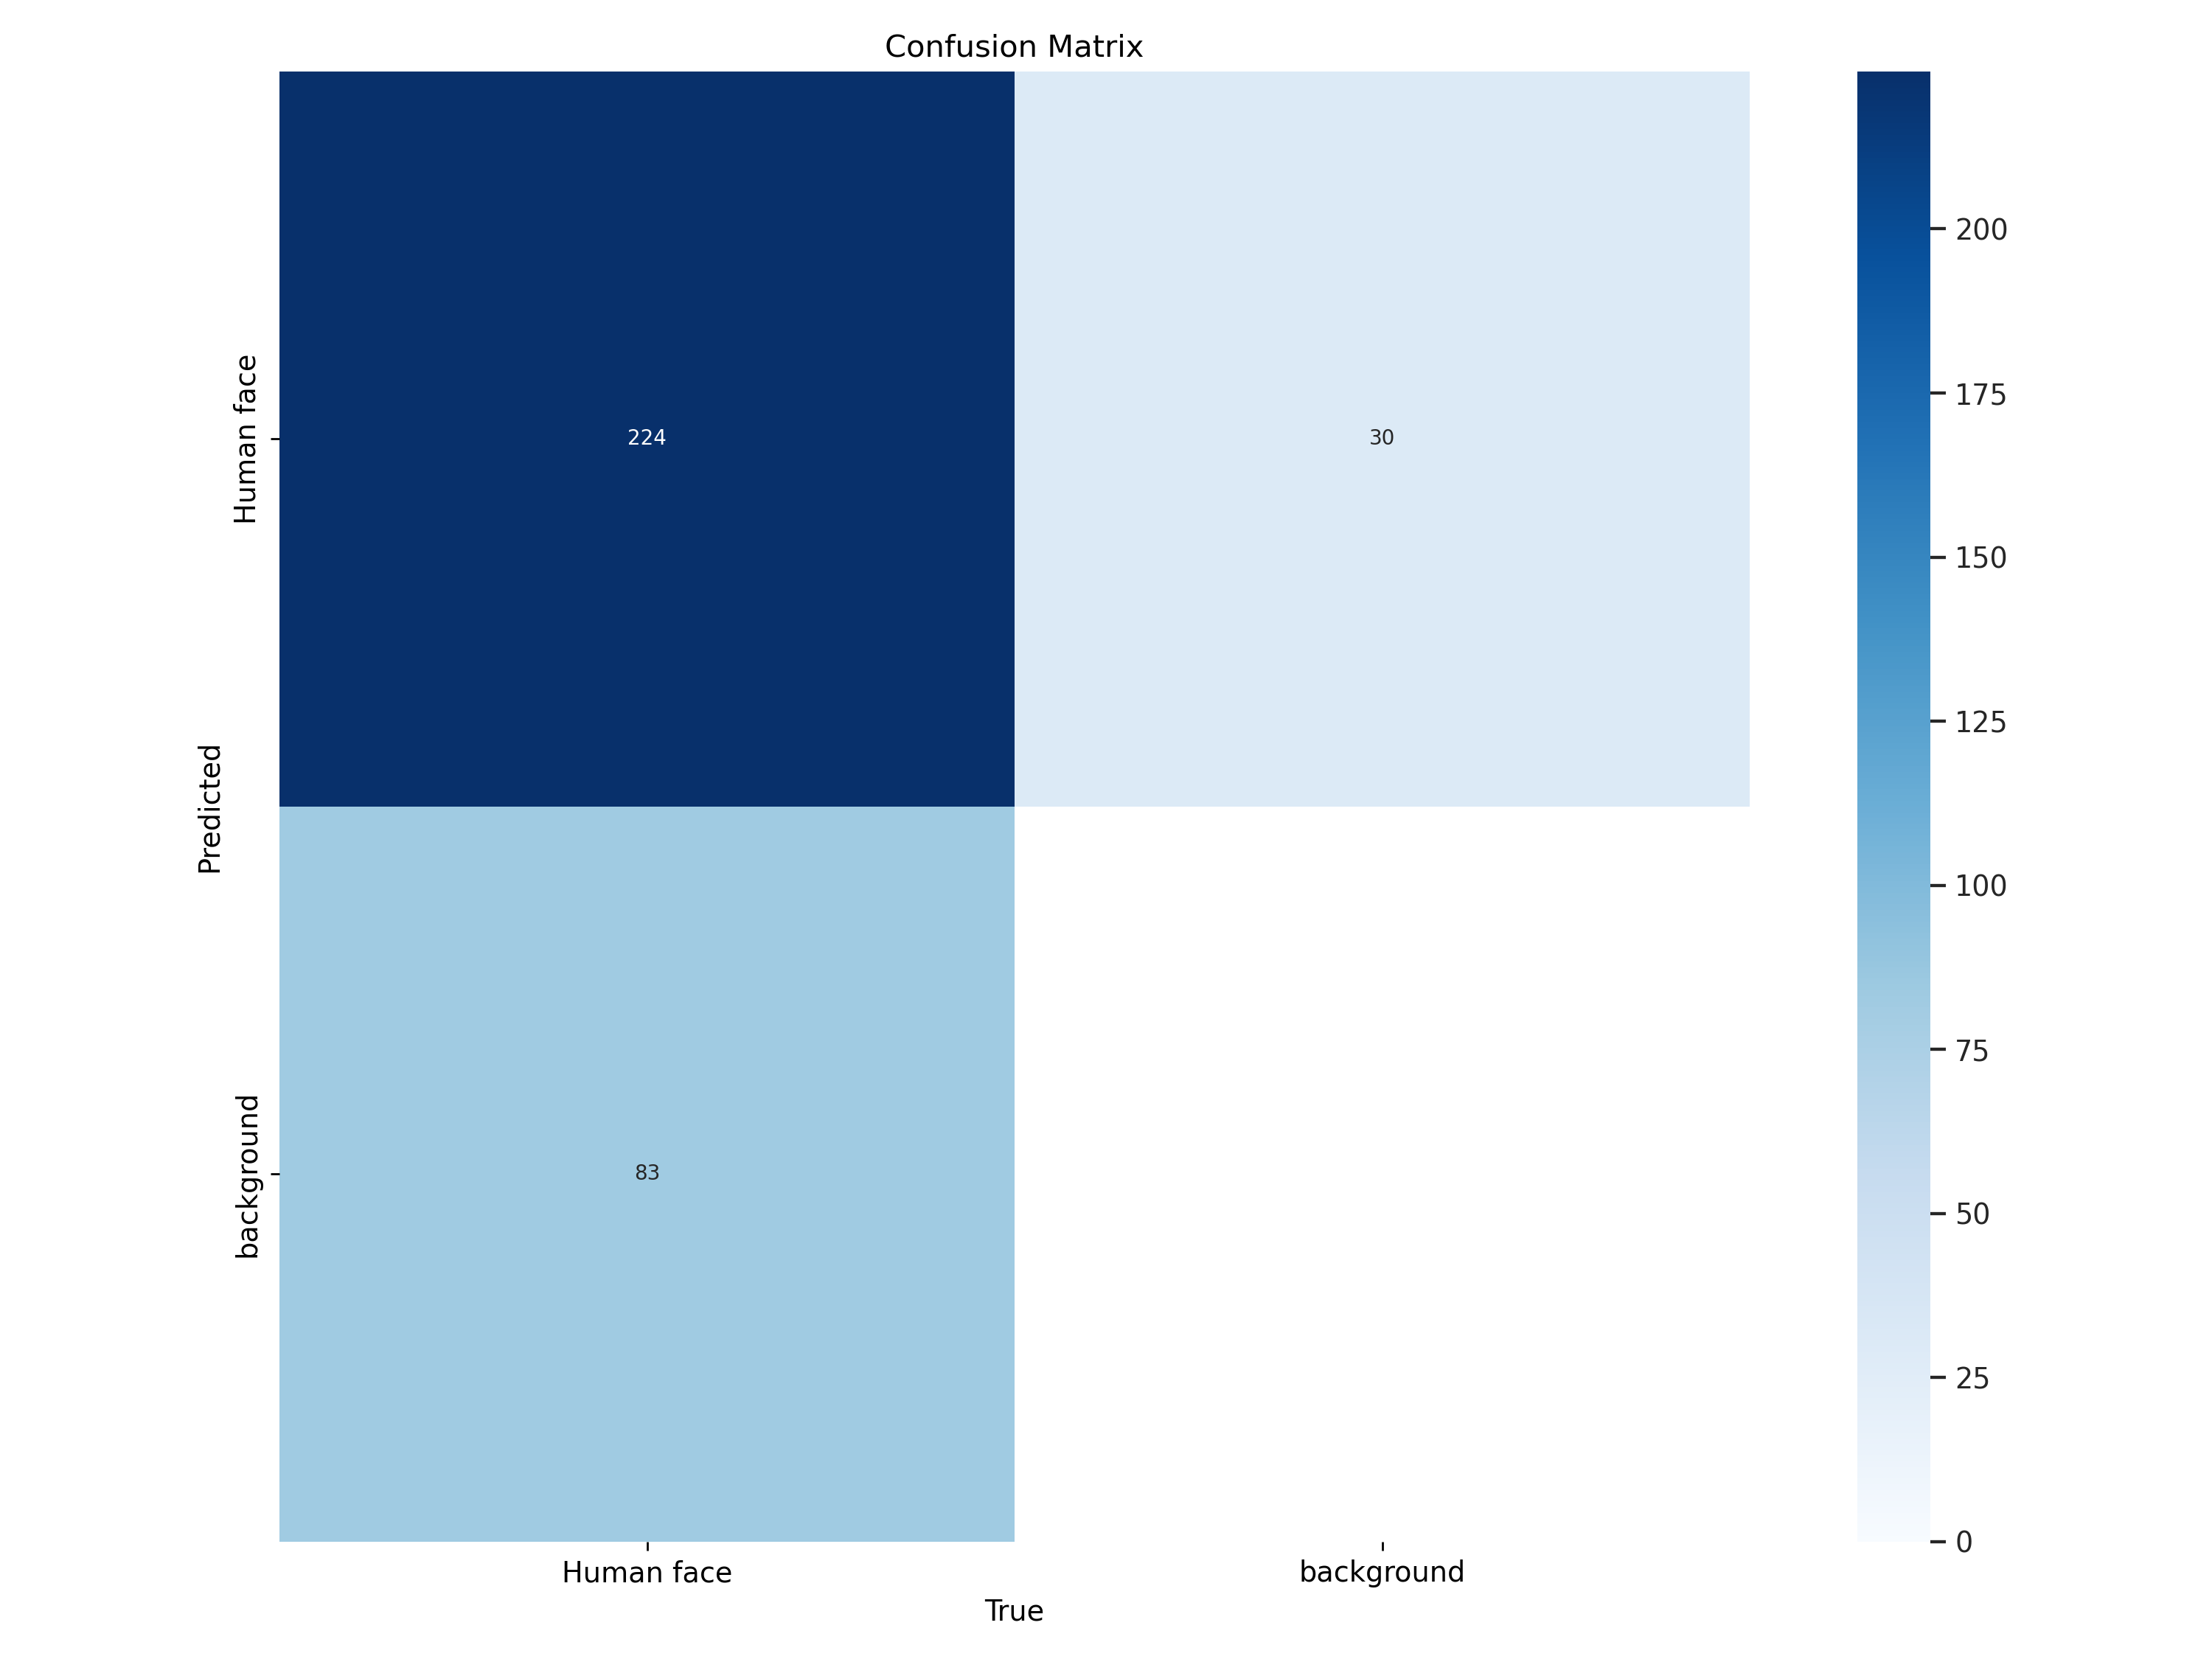

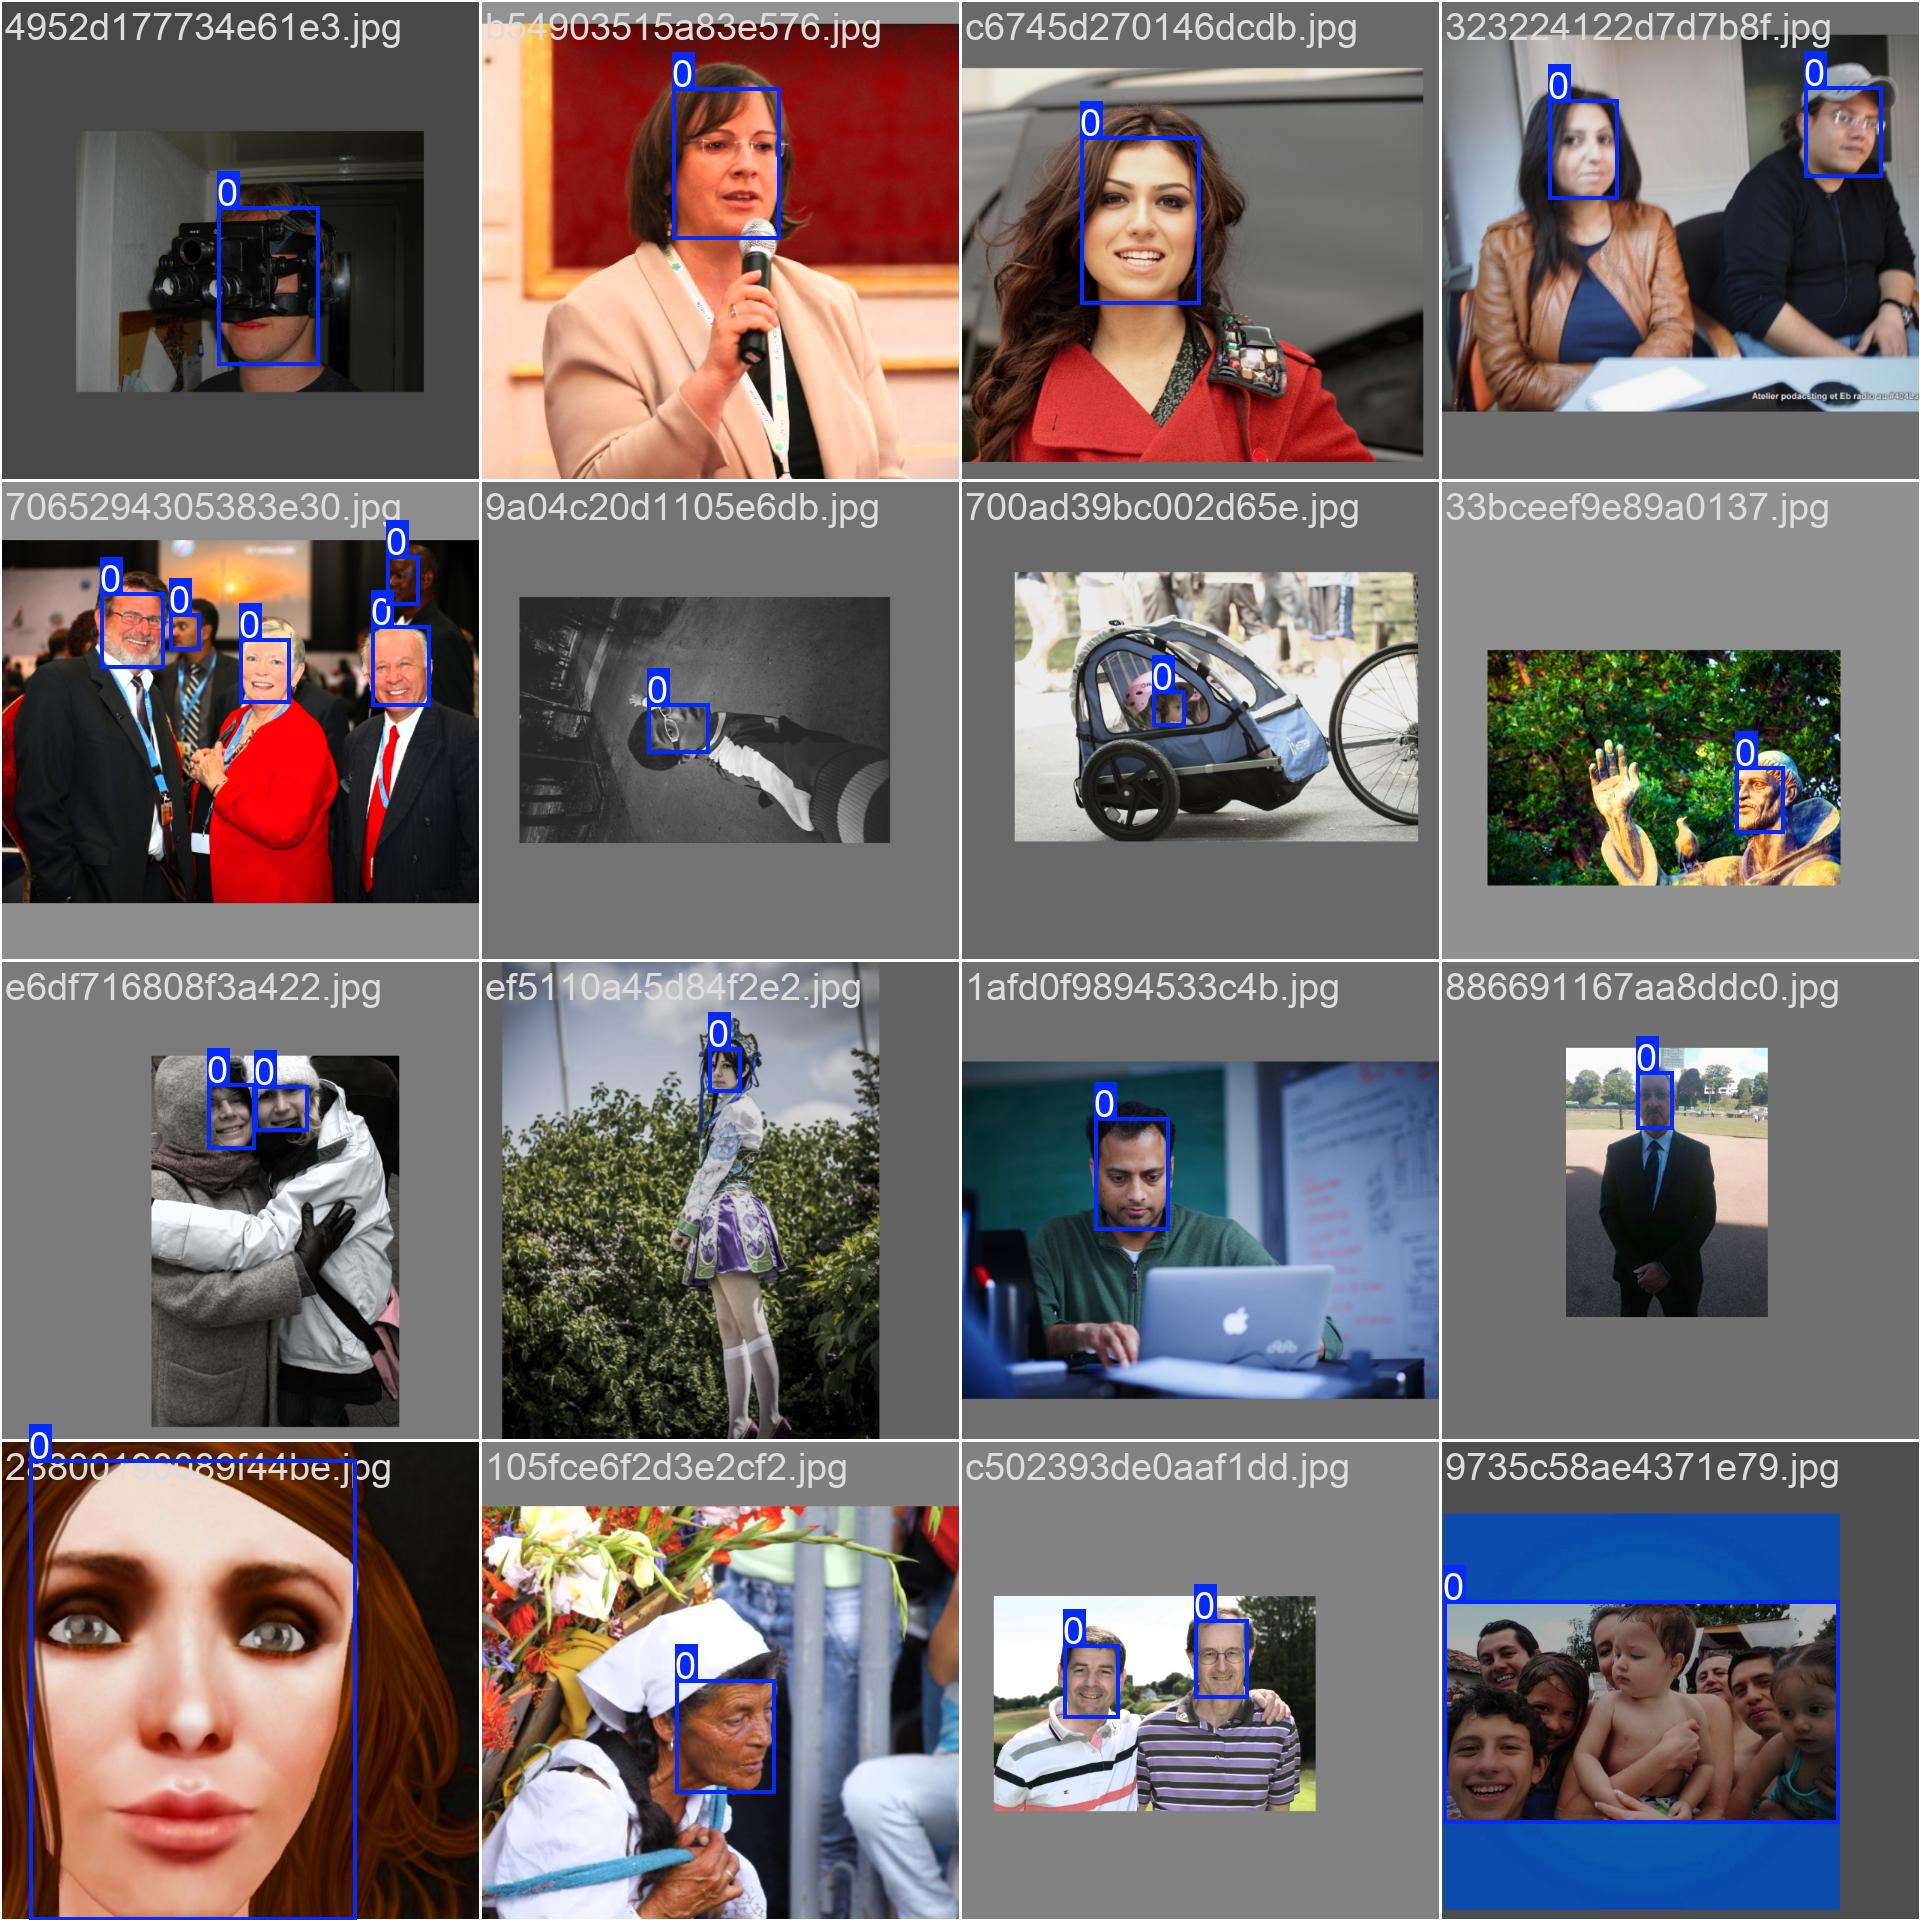

In [95]:
display(Image("runs/detect/yolo_humanface2/results.png", width=1000))
display(Image("runs/detect/yolo_humanface2/confusion_matrix.png", width=800))
display(Image("runs/detect/yolo_humanface2/train_batch2001.jpg", width=800))

### Usage Verification and Test
Next, we provide some unseen test examples that may be representative of our use case, the safety glasses scenario. We validate that the model detects well with diverse sample images from google images. Note as well that the data is unlabeled and clean. The model outputs are displayed below as well. We can observe the model has no trouble with this small test dataset.

In [ ]:
torch.cuda.empty_cache()
model = YOLO('runs/detect/yolo_humanface2/weights/best.pt')

results = model.predict(["safetyglasses_googlesearch1.PNG",
                         "safetyglasses_googlesearch2.PNG",
                         "safetyglasses_googlesearch3.PNG"],
                        save = True,
                        )
# for result in results:
#     boxes = result.boxes  # Boxes object for bounding box outputs
#     masks = result.masks  # Masks object for segmentation masks outputs
#     keypoints = result.keypoints  # Keypoints object for pose outputs
#     probs = result.probs  # Probs object for classification outputs
#     obb = result.obb  # Oriented boxes object for OBB outputs
#     result.show()  # display to screen
#     result.save(filename="result.jpg")  # save to disk

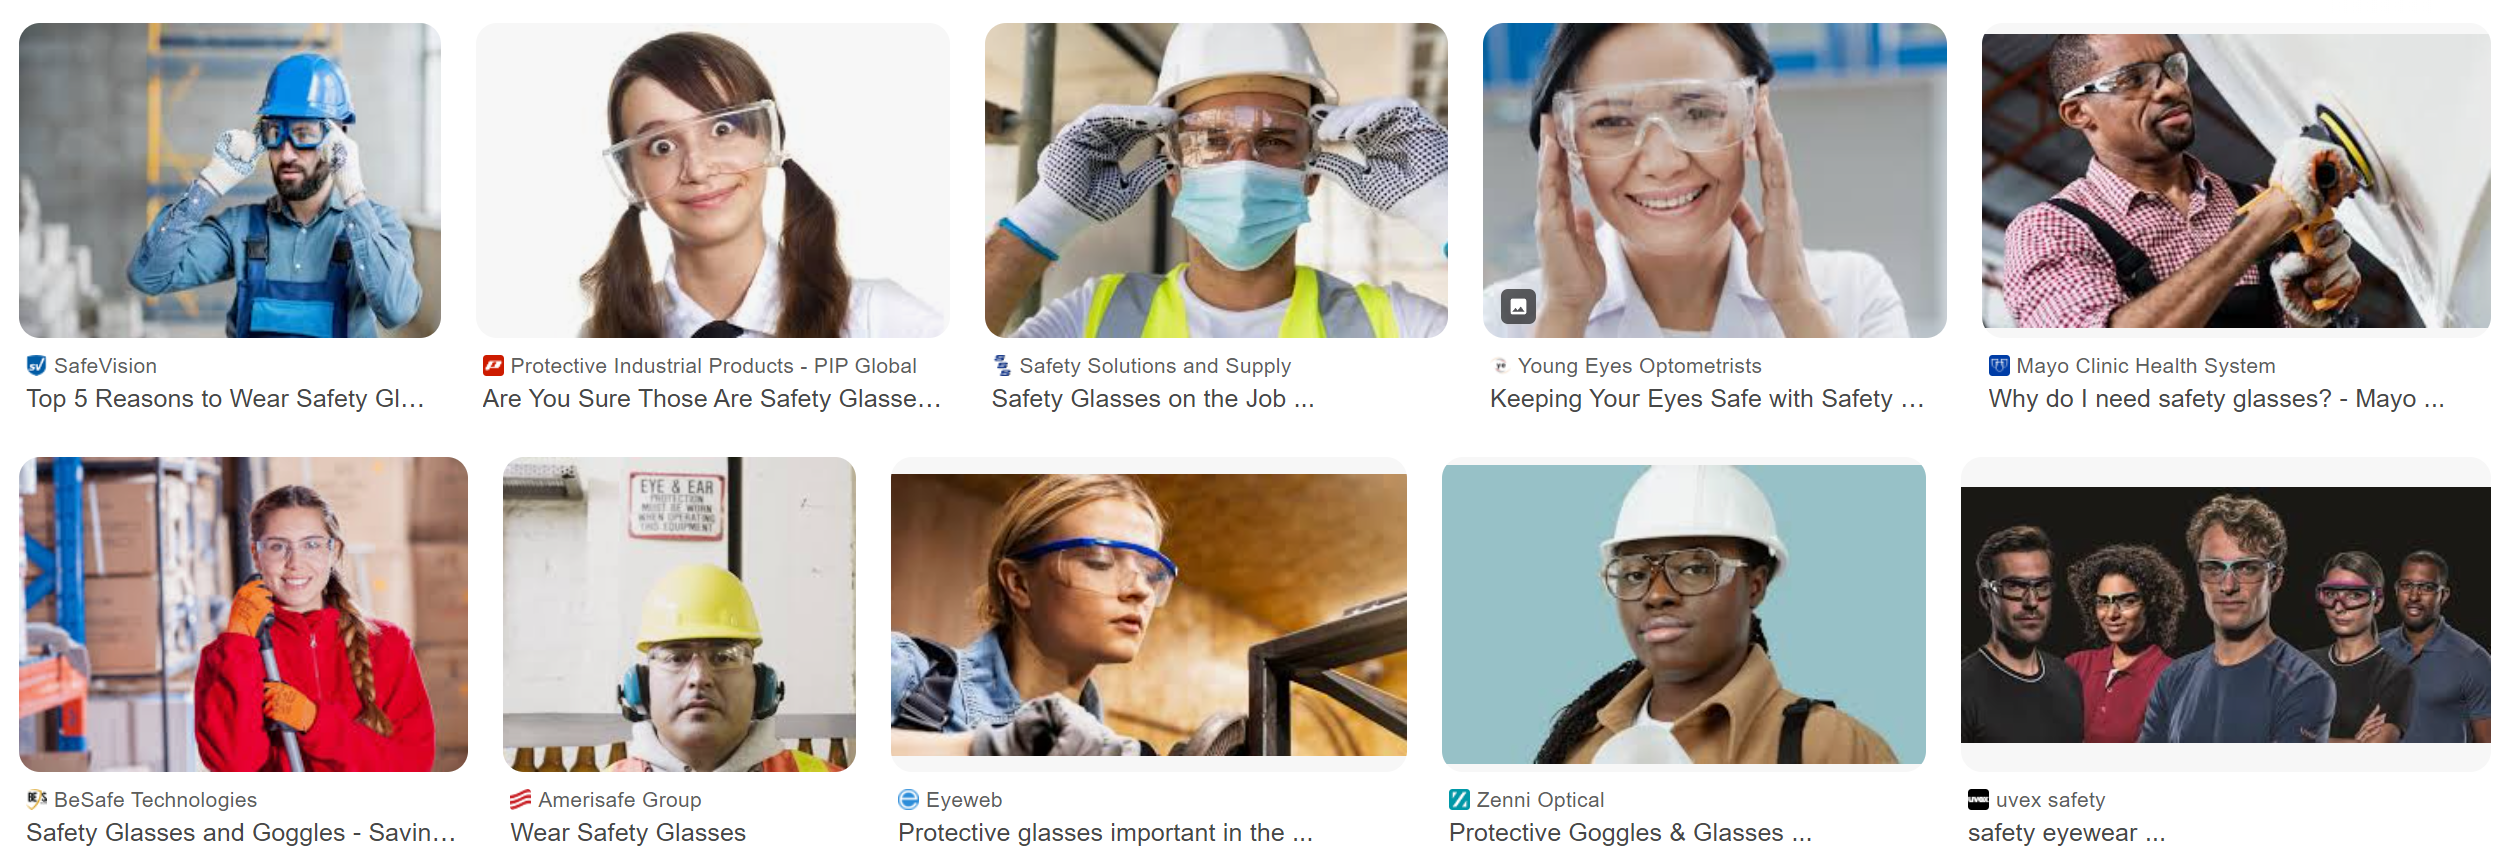

In [12]:
# Input Image
Image("safetyglasses_googlesearch.png")

outputs with bounding boxes

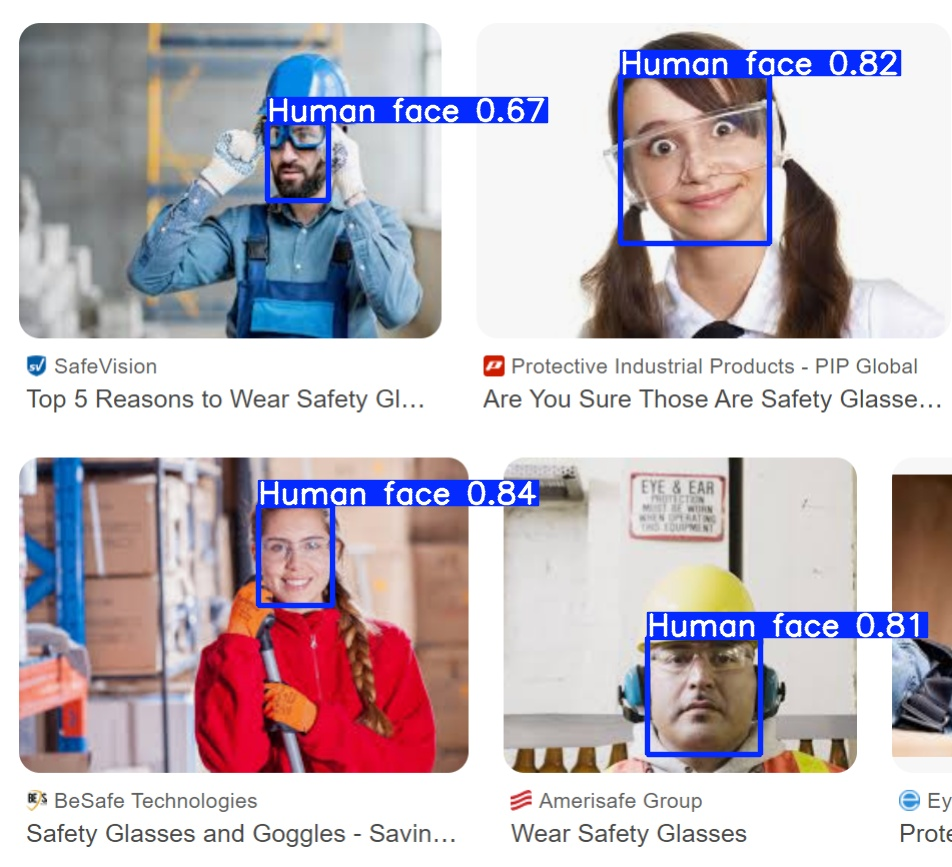

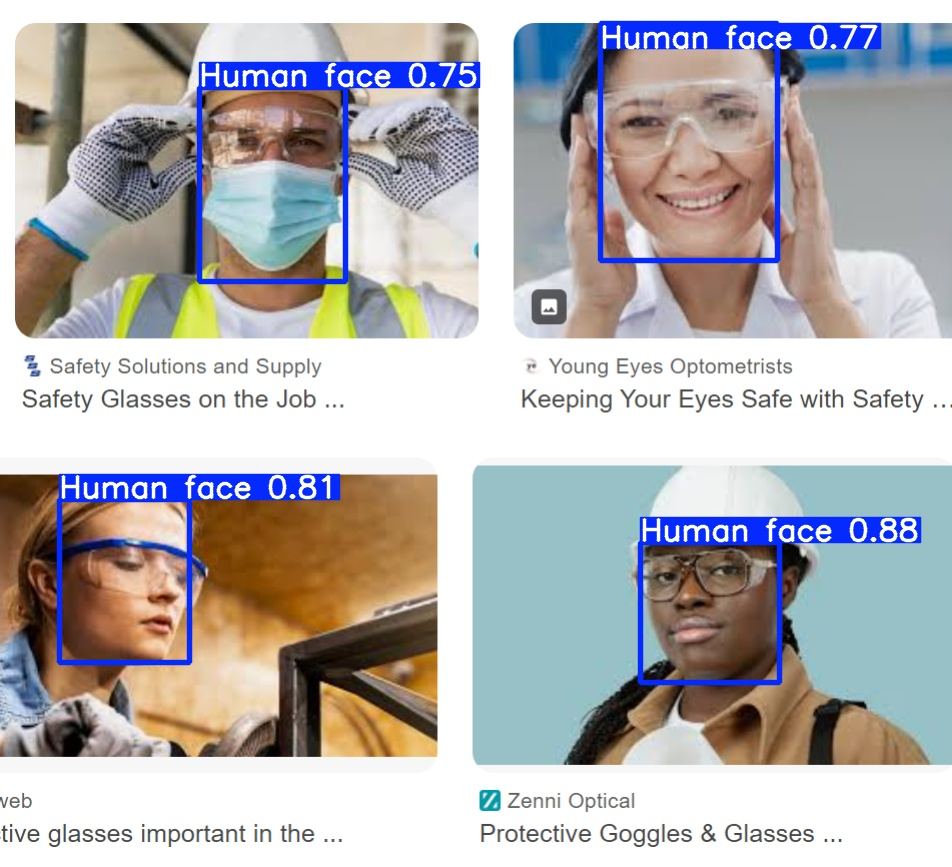

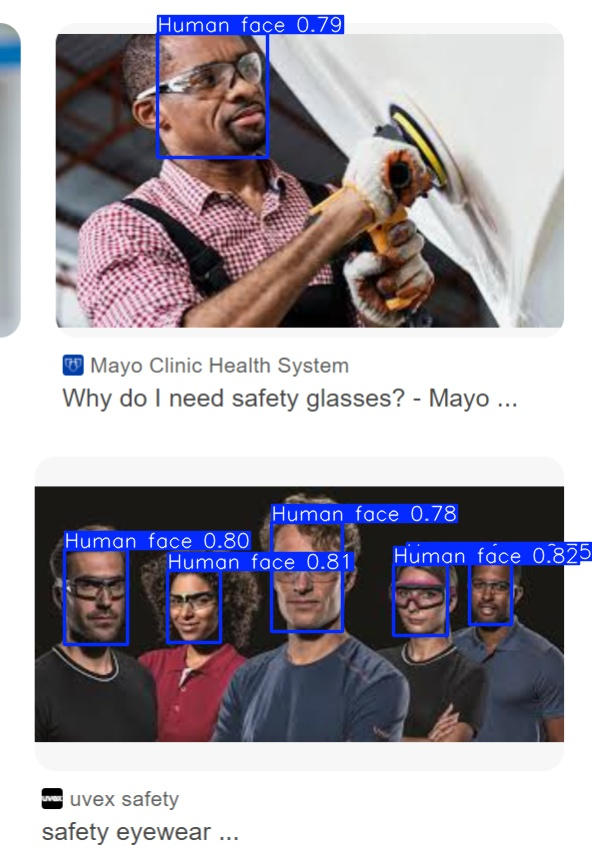

In [96]:
display(Image("runs/detect/predict2/safetyglasses_googlesearch1.jpg", width=600))
display(Image("runs/detect/predict2/safetyglasses_googlesearch2.jpg", width=600))
display(Image("runs/detect/predict2/safetyglasses_googlesearch3.jpg", width=600))

## Classification Model 

Next in the pipeline is the classification model. In the next steps, the classifier will be fed the cropped images outlined by the YOLO detector. We have three classes; Glasses, No Glasses, and Safety Glasses. Ideally, the model will be able to distinguish between the three classes through learning some latent information - specifically between the glasses and safety eyewear images.

### Data Collection and Visualization

Data was collected through several methods, with precautions taken to prevent data leakage or biases towards specific classes. Many images were collected from Kaggle, both from [GAN-generated datasets](https://www.kaggle.com/datasets/jeffheaton/glasses-or-no-glasses/data) and [real faces](https://www.kaggle.com/datasets/xhlulu/flickrfaceshq-dataset-nvidia-part-1).  Protective eyewear data was also collected from a kaggle dataset [here](https://www.kaggle.com/datasets/mugheesahmad/sh17-dataset-for-ppe-detection).  We ensure images with general protective equipment are included in both the glasses and no glasses training and validation sets as to normalize features and prevent the classifier from overfitting on general PPE for the safety class. Additional data was then scraped from google images to further reduce bias in the non-safety datasets and provide more training variation.

We use the [splitfolders](https://pypi.org/project/split-folders/) Python module to easily split data as needed and at random. We can see the resulting data split is as follows - 428 train, 53 validation, 54 test.

To visualize the dataset, we present some visualization code:

In [52]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    ])

input_dir = 'eyewear/Dataset'
output_dir = 'eyewear/Dataset_split'

splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(0.8, 0.1, 0.1), group_prefix=None)

# Define directories for train, val, and test sets
train_dir = 'eyewear/Dataset_split/train'
val_dir = 'eyewear/Dataset_split/val'
test_dir = 'eyewear/Dataset_split/test'

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Copying files: 535 files [00:09, 57.09 files/s] 


In [23]:
total_samples = len(train_dataset) + len(val_dataset) + len(test_dataset)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Total Samples: {total_samples}")

Number of training samples: 428
Number of validation samples: 53
Number of test samples: 54
Total Samples: 535


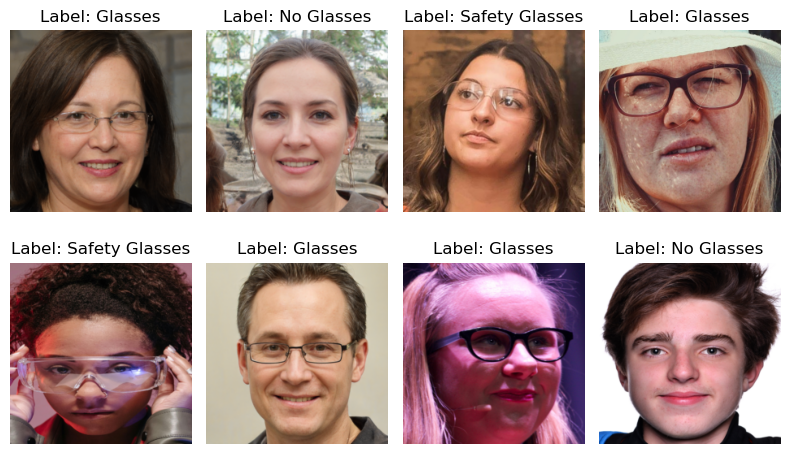

In [25]:
def visualize_dataset(dataset, num_samples=9):
    # Create a grid of subplots
    fig, axes = plt.subplots(2, 4, figsize=(8, 5))
    axes = axes.flatten()
    
    # Randomly select samples from the dataset
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for ax, idx in zip(axes, indices):
        image, label = dataset[idx]
        ax.imshow(image.permute(1, 2, 0))  # Rearrange dimensions for displaying (C, H, W) -> (H, W, C)
        ax.set_title(f'Label: {dataset.classes[label]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_dataset(train_dataset, num_samples=12)

### Feature Extraction
Next, we pass the images through alexnet to extract alexnet features, leveraging the pretrained classifier - hopefully to improve results on our limited (~500 examples) dataset. Features are saved locally as pytorch tensors.

In [62]:
def compute_save_features(data_loader, save_path, alexnet):
    all_features = []
    all_labels = []
    
    for images, labels in tqdm(data_loader):
        #print("Raw image shape:", images.shape)
        # Ensure images are in the correct format (3 channels)
        if images.shape[1] != 3:
            raise ValueError(f"Expected 3 channels, got {images.shape[1]}")
        
        with torch.no_grad():
            # Extract features using AlexNet feature layers
            features = alexnet.features(images)
            #print("Feature shape after AlexNet extraction:", features.shape)
            
        # Convert features tensor to NumPy array and detach from computational graph
        features_np = features.cpu().numpy()
        labels_np = labels.cpu().numpy()
        # Collect all features and labels for saving
        all_features.append(features_np)
        all_labels.append(labels_np)
    
    # Concatenate all feature arrays into a single array
    all_features_np = np.concatenate(all_features, axis=0)
    all_labels_np = np.concatenate(all_labels, axis=0)
    
    # Save features and labels
    os.makedirs(os.path.join(os.getcwd(), os.path.dirname(save_path)), exist_ok=True)
    torch.save(torch.tensor(all_features_np), os.path.join(os.getcwd(), save_path + "_features.pth"))
    torch.save(torch.tensor(all_labels_np), os.path.join(os.getcwd(), save_path + "_labels.pth"))

alexnet = torchvision.models.alexnet(pretrained=True)

# Compute and save features for training, validation, and testing
compute_save_features(train_loader, "eyewear/featureset/train_features", alexnet)
compute_save_features(val_loader, "eyewear/featureset/val_features", alexnet)
compute_save_features(test_loader, "eyewear/featureset/test_features", alexnet)

/home/connor/miniconda3/envs/mie1517/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/connor/miniconda3/envs/mie1517/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


### Classifier Architecture and Training

Currently, we implement simple fully connected layers as our classifier, acting on the features extracted by the alexnet model. The implementation is as follows, as well as the training loop and evaluation code.

#### Architecture

In [43]:
class FCCNet(nn.Module):
    def __init__(self):
        super(FCCNet, self).__init__()
        self.name = "FCClassifier"
        self.fc1 = nn.Linear(256 * 6 * 6, 64)
        self.fc2 = nn.Linear(64, 9)

    def forward(self, x):
        x = x.reshape(-1, 256 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Training Loop and Evaluation Functions
Adapted from MIE1517 Assignments

In [60]:
def evaluate(net, data_loader, criterion, device):
    class_labels = ['Glasses', 'No Glasses', 'Safety Glasses']
    
    net.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # No need to track gradients during evaluation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect all labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    average_loss = total_loss / len(data_loader)

    return 1 - accuracy, average_loss  # Return error rate and average loss

def confusion_evaluate(net, data_loader, criterion, device):
    class_labels = ['Glasses', 'No Glasses', 'Safety Glasses']
    
    net.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # No need to track gradients during evaluation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect all labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    average_loss = total_loss / len(data_loader)
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=np.arange(len(class_labels)))

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate and print accuracy for each class
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    for i, class_label in enumerate(class_labels):
        print(f"Accuracy for class {class_label}: {class_accuracies[i] * 100:.2f}%")

    return 1 - accuracy, average_loss  # Return error rate and average loss

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_training_curve(path):
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def train_net(net, train_loader, val_loader, batch_size, learning_rate, num_epochs, device):
    if torch.cuda.is_available():
        net.to(device)

    torch.manual_seed(1000)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    start_time = time.time()
    
    for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0

        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data               
            
            if torch.cuda.is_available():
                inputs = inputs.to(device)
                labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            # Calculate the statistics
            _, predicted = torch.max(outputs, 1)
            total_train_err += (predicted != labels).sum().item()
            total_train_loss += loss.item()
            total_epoch += len(labels)

        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion, device)
        print(("Epoch {}: Train err: {:.4f}, Train loss: {:.4f} | " +
                "Validation err: {:.4f}, Validation loss: {:.4f}").format(
                    epoch + 1,
                    train_err[epoch],
                    train_loss[epoch],
                    val_err[epoch],
                    val_loss[epoch]))
        
    model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
    torch.save(net.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

Loading our pre-saved features,

In [64]:
def load_features_labels(file_path):
    features = torch.load(file_path + "_features.pth", weights_only=False)
    labels = torch.load(file_path + "_labels.pth", weights_only=False)
    # Detach features from computational graph to avoid tracking updates
    features = torch.from_numpy(features.detach().numpy())
    return features, labels

# Load precomputed features and labels for training, validation, and test data
train_features, train_labels = load_features_labels("eyewear/featureset/train_features")
val_features, val_labels = load_features_labels("eyewear/featureset/val_features")
test_features, test_labels = load_features_labels("eyewear/featureset/test_features")

# Convert labels to LongTensor
train_labels, val_labels, test_labels = train_labels.long(), val_labels.long(), test_labels.long()

# Create DataLoader instances for training, validation, and test data
train_featureset = torch.utils.data.TensorDataset(train_features, train_labels) 
val_featureset = torch.utils.data.TensorDataset(val_features, val_labels)
test_featureset = torch.utils.data.TensorDataset(test_features, test_labels)

batch_size = 64
feature_train_loader = torch.utils.data.DataLoader(train_featureset, batch_size=batch_size, shuffle=True)
feature_val_loader = torch.utils.data.DataLoader(val_featureset, batch_size=batch_size, shuffle=False)
feature_test_loader = torch.utils.data.DataLoader(test_featureset, batch_size=batch_size, shuffle=False)

# Verification Step - obtain one batch of features
dataiter = iter(feature_train_loader)
feature, label = next(dataiter)
print(feature.shape)
print(label.shape)

torch.Size([64, 256, 6, 6])
torch.Size([64])


And finally demonstrating a simple training loop with known well-performing hyperparameters

Using GPU...


 33%|███▎      | 5/15 [00:00<00:00, 11.48it/s]

Epoch 1: Train err: 0.5678, Train loss: 1.8580 | Validation err: 0.5660, Validation loss: 2.0463
Epoch 2: Train err: 0.3248, Train loss: 1.0564 | Validation err: 0.2075, Validation loss: 0.6657
Epoch 3: Train err: 0.1215, Train loss: 0.3314 | Validation err: 0.2264, Validation loss: 0.9950
Epoch 4: Train err: 0.0911, Train loss: 0.2203 | Validation err: 0.1698, Validation loss: 0.9774
Epoch 5: Train err: 0.0467, Train loss: 0.1440 | Validation err: 0.3019, Validation loss: 1.4918
Epoch 6: Train err: 0.0654, Train loss: 0.1898 | Validation err: 0.2075, Validation loss: 1.2942
Epoch 7: Train err: 0.0607, Train loss: 0.1405 | Validation err: 0.1698, Validation loss: 1.1189
Epoch 8: Train err: 0.0140, Train loss: 0.0451 | Validation err: 0.1698, Validation loss: 1.2609


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]

Epoch 9: Train err: 0.0047, Train loss: 0.0154 | Validation err: 0.1509, Validation loss: 0.9613
Epoch 10: Train err: 0.0047, Train loss: 0.0139 | Validation err: 0.1887, Validation loss: 1.2686
Epoch 11: Train err: 0.0000, Train loss: 0.0031 | Validation err: 0.1698, Validation loss: 1.0693
Epoch 12: Train err: 0.0000, Train loss: 0.0013 | Validation err: 0.1698, Validation loss: 1.0733
Epoch 13: Train err: 0.0000, Train loss: 0.0006 | Validation err: 0.1509, Validation loss: 1.0886
Epoch 14: Train err: 0.0000, Train loss: 0.0005 | Validation err: 0.1509, Validation loss: 1.0977
Epoch 15: Train err: 0.0000, Train loss: 0.0005 | Validation err: 0.1509, Validation loss: 1.0941
Finished Training
Total time elapsed: 0.83 seconds
Finished Training
Total time elapsed: 0.84 seconds
Transfer_Net_1:


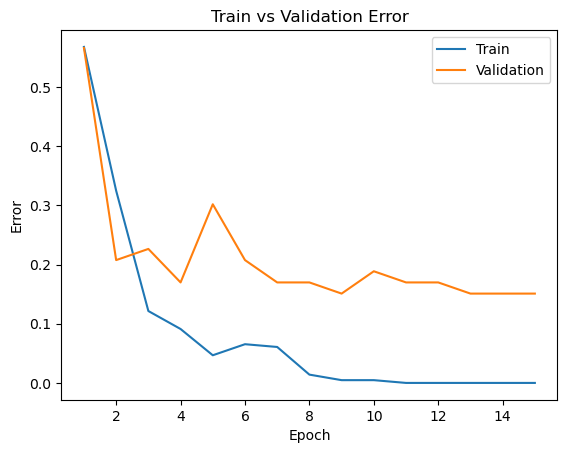

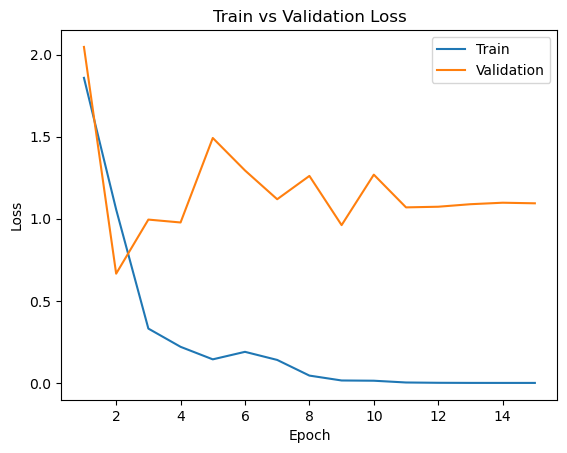

In [65]:
model = FCCNet()
batch_size = 64
learning_rate = 0.01
num_epochs = 15

if torch.cuda.is_available():
    print("Using GPU...")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

train_net(model, feature_train_loader, feature_val_loader, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs, device=device)

print(f'Transfer_Net_1:')
plot_training_curve(get_model_name(model.name, batch_size, learning_rate, num_epochs - 1))


#### Test Results
Here we present results with the test set, with class accuracies and confusion matrix.

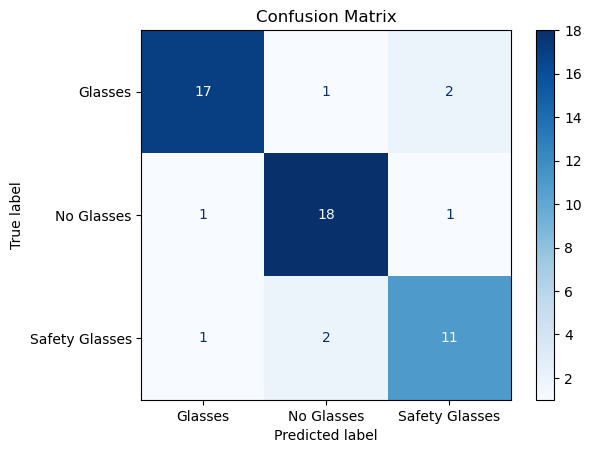

Accuracy for class Glasses: 85.00%
Accuracy for class No Glasses: 90.00%
Accuracy for class Safety Glasses: 78.57%

Test Classification Accuracy: 0.8518518518518519


In [74]:
import gc
try:
    del net
except:
    pass
gc.collect()
torch.cuda.empty_cache()

net = FCCNet()
model_path = get_model_name(net.name, batch_size=batch_size, learning_rate=learning_rate, epoch=num_epochs-1,)
state = torch.load(model_path, weights_only=True)
net.load_state_dict(state)
net.eval()
net.to(device)

test_error = confusion_evaluate(net, feature_test_loader, nn.CrossEntropyLoss(), device=device)
print(f'\nTest Classification Accuracy: {1-test_error[0]}')

### Classifier Overview
Thus, we have presented a strong argument for the validity of the model. It is capable of detecting features within the dataset to determine whether a face is wearing glasses or no glasses, and further determine if they are protective eyewear. The remaining material in the project mainly consists of further validation, collecting real world test data, and building code architecture to automate passing data in to the classifier from the YOLO detection model.